In [26]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [27]:
front_2Dcoord = np.load('front_image.npy', allow_pickle=True)
back_2Dcoord = np.load('back_image.npy', allow_pickle=True)
front_img = cv2.imread('front.png')

(12, 2) (12, 2)


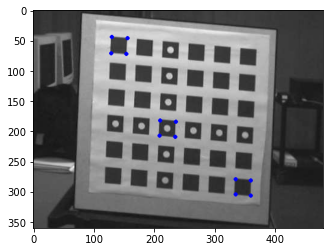

In [28]:
#visualization
print(front_2Dcoord.shape, back_2Dcoord.shape)
from copy import deepcopy
vis_img = deepcopy(front_img)
for i in range(front_2Dcoord.shape[0]):
    cv2.circle(vis_img, (int(front_2Dcoord[i,0]), int(front_2Dcoord[i,1])), 2, (255,0,0), 2)
plt.imshow(vis_img[:,:,::-1])
plt.show()

In [29]:
# ------------TODO----------------
# Compute corresponding 3D coordinate
# ------------TODO----------------


# >>> Compute corresponding 3D coordinate >>>
def get_3d_coord(pic_id, grid_x, grid_y, pos):
    z = 0 if pic_id == 0 else 150
    x = 80 * grid_x
    y = 80 * grid_y
    if   pos == 0: pass
    elif pos == 1: x += 50
    elif pos == 2: x += 50; y += 50
    elif pos == 3: y += 50
    return [x, y, z]

front_3Dcoord = np.array([get_3d_coord(0, gx, gy, pos) for (gx, gy, pos) in [
    (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3),
    (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3),
    (5, 5, 0), (5, 5, 1), (5, 5, 2), (5, 5, 3),
]], dtype="f8")

back_3Dcoord = np.array([get_3d_coord(1, gx, gy, pos) for (gx, gy, pos) in [
    (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3),
    (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3),
    (5, 5, 0), (5, 5, 1), (5, 5, 2), (5, 5, 3),
]], dtype="f8")
# <<< Compute corresponding 3D coordinate <<<

all_2Dcoord = np.concatenate((front_2Dcoord, back_2Dcoord), axis=0)
all_3Dcoord = np.concatenate((front_3Dcoord, back_3Dcoord), axis=0)
print(all_2Dcoord.shape, all_3Dcoord.shape)

(24, 2) (24, 3)


In [30]:
# ------------TODO----------------
# Construct the Equation Pm=0 and solve m
# ------------TODO----------------

#>>> Construct Matrix P >>>
P = np.zeros((48, 12))
n_points = all_2Dcoord.shape[0]
for i in range(n_points):
    Pi = np.hstack([all_3Dcoord[i], 1])     # [x, y, z] -> [x, y, z, 1]
    zero = [0, 0, 0, 0]
    ui, vi = all_2Dcoord[i]
    P[i * 2]   =   np.hstack([Pi, zero, -ui * Pi])
    P[i * 2 + 1] = np.hstack([zero, Pi, -vi * Pi])
#<<< Construct Matrix P <<<

#>>> Solve "m" for Pm=0 >>>
U, S, VT = np.linalg.svd(P)
m = VT[-1]
#<<< Solve "m" for Pm=0 <<<

In [31]:
# ------------TODO----------------
# Solve K, and [R T] from m
# ------------TODO----------------

M_hat = m.reshape((3, 4)).copy()
a1_hat, a2_hat, a3_hat = A_hat = M_hat[:, :3]
b1_hat, b2_hat, b3_hat = b_hat = M_hat[:, 3:]

rho = 1 / np.linalg.norm(a3_hat)
rho2 = rho ** 2
cross_a1_a3 = np.cross(a1_hat, a3_hat)
cross_a2_a3 = np.cross(a2_hat, a3_hat)
norm_c13 = np.linalg.norm(cross_a1_a3)
norm_c23 = np.linalg.norm(cross_a2_a3)

u0 = rho2 * np.dot(a1_hat, a3_hat)
v0 = rho2 * np.dot(a2_hat, a3_hat)
# theta = np.arccos(-np.dot(cross_a1_a3, cross_a2_a3) / (norm_c13 * norm_c23))
theta = np.arccos(-np.dot(cross_a1_a3, cross_a2_a3) / (norm_c13 * norm_c23))
alpha = rho2 * norm_c13 * np.sin(theta)
beta = rho2 * norm_c23 * np.sin(theta)

# Intrinsic: K
K = np.array([
    alpha, -alpha / np.tan(theta), u0,
    0, beta / np.sin(theta), v0,
    0, 0, 1]
).reshape(3, 3)

# Extrinsic: [R, T]
r1 = cross_a2_a3 / norm_c23
r3 = a3_hat / np.linalg.norm(a3_hat)
r2 = np.cross(r3, r1)
R = np.vstack([r1, r2, r3])
T = rho * np.linalg.inv(K) @ b_hat

# 断言 M == ρM^
assert np.allclose(M := K @ np.hstack([R, T]), M_hat * rho)

In [32]:
# save results
save_dict = {'3Dcoord': all_3Dcoord, 'P':P, 'm':m, 'K':K, 'R':R, 'T':T}
np.save('../results/calibr', save_dict)